## Strategy Overview

This post was adapted from the technical take-home project given by AVM Capital (macro hedge fund) for the Quant Analyst Intern position. The original objective was: given some macroeconomic data of inflation and growth, come up with an ideal hedging strategy for the S&P. After some discussion, this was adapted to: come up with a strategy to beat the benchmark of long S&P by constructing a long-short portfolio consisting of the S&P 500, Gold, and US10Y treasury bonds. 

The data given to me was daily close of S&P, quarterly close of Gold, daily yields of US10Y bonds, quarterly GDP YoY change figures and monthly CPI YoY change figures, from 1970 to 2020. Thus, my strategy was to rebalance the portfolio quarterly based on the current regime the quarter was in, determined by whether growth or inflation was rising/falling from the previous quarter. The in-sample period is from 1970 to 2012 and the out-sample period is from 2013-2020. I then evaluate the out-sample performance based on the rolling Sharpe, rolling information ratio and tracking error.

In [185]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set_style('darkgrid')

def retrieve_sheets(path):
    
    dfs = pd.read_excel(path, parse_dates=True, sheet_name=None, index_col='Date')
    macro = dfs['Macro'].fillna(method='bfill').resample('Q').mean().round(2)
    prices = dfs['Prices'].fillna(method='bfill')
    yields = dfs['Yield']

    return macro, prices, yields


macro, prices, yields = retrieve_sheets(fr'data\avm_data.xlsx')

C:\Users\Ryan\AppData\Local\Temp\ipykernel_17032\772517164.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  macro = dfs['Macro'].fillna(method='bfill').resample('Q').mean().round(2)


Text(0.5, 1.0, 'S&P and Gold, 1970-2022')

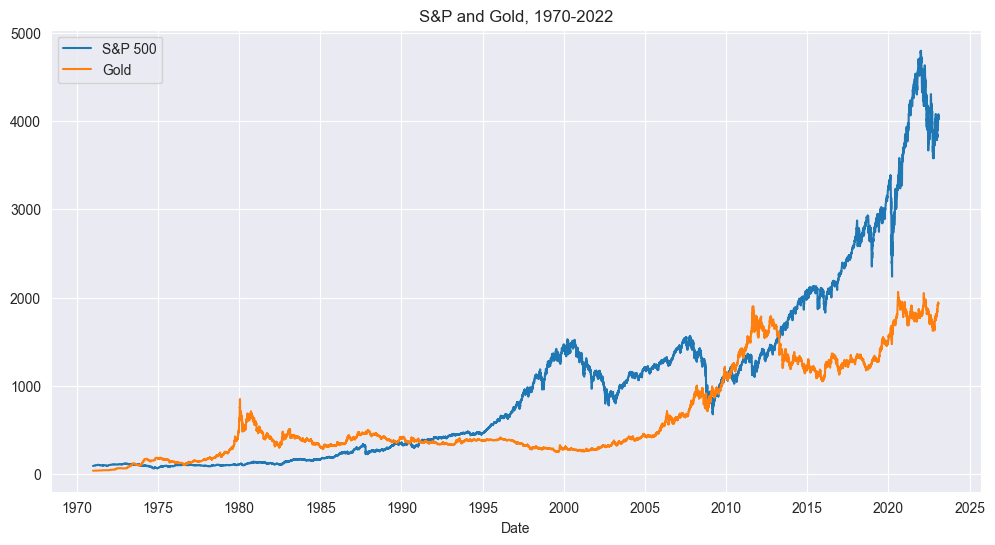

In [194]:
fig, ax = plt.subplots(figsize=(12,6))

year_locator = mdates.YearLocator(5)
ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
sns.lineplot(prices.iloc[:,:2], dashes=False)
plt.title('S&P and Gold, 1970-2022')


First, we examine the overall plot of quarterly growth and inflation figures.

Text(0.5, 1.0, 'Quarterly GDP/CPI YoY change in %, 1970-2020')

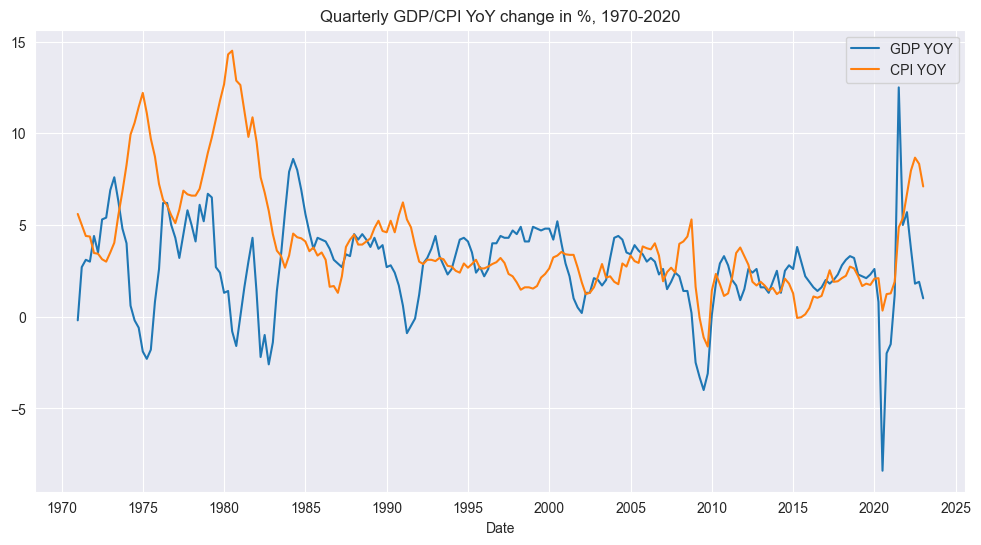

In [4]:
fig, ax = plt.subplots(figsize=(12,6))

year_locator = mdates.YearLocator(5)
ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
sns.lineplot(macro, dashes=False)
plt.title('Quarterly GDP/CPI YoY change in %, 1970-2020')

# Data Prep

Next, we create log quarterly returns.

In [24]:
def create_returns(prices, yields):

    prices['SR'] = np.log(prices['S&P 500']) - np.log(prices['S&P 500'].shift(1))
    prices['GR'] = np.log(prices['Gold']) - np.log(prices['Gold'].shift(1))
    yields['YR'] = np.log(yields['US 10YR Bonds']) - np.log(yields['US 10YR Bonds'].shift(1))
    
    rets = pd.merge(prices, yields['YR'], left_index=True, right_index=True)[['SR', 'GR', 'YR']]
    return rets.resample('Q').sum()
    
df = create_returns(prices, yields)

# Assigning Regimes

Given the CPI and GDP data, we can classify any period in this time horizon into whether it has rising or falling growth or inflation relative to the previous year. We categorize an indicator as rising if it is greater than the previous quarter and falling if it is lesser than the previous quarters values. Thus, this gives us very simplistic categories:

0. Deflation - Falling growth, falling inflation
1. Stagflation - Falling growth, rising inflation  
2. Bullish - Rising growth, falling inflation  
3. Overheating - Rising growth, rising inflation 

In [133]:
def assign_regimes(df, macro):
    regimes = pd.DataFrame(index=macro.index)
    regimes['g'] = np.where(macro['GDP YOY'] > (macro['GDP YOY'].shift(1)), 1, 0)
    regimes['i'] = np.where(macro['CPI YOY'] > (macro['CPI YOY'].shift(1)), 1, 0)
    regimes['regime'] = (regimes.g.astype(str) + regimes.i.astype(str)).apply(lambda x: int(x,2))
    print(regimes.groupby('regime').count().g)
    return df.merge(regimes.regime,left_index=True, right_index=True,how='inner').dropna()

def split_rets(rets, date):
    train, test = rets[rets.index < date], rets[rets.index >= date]
    return train, test

rets = assign_regimes(df, macro)
train, test = split_rets(rets, '2012-01-01')

regime
0    54
1    62
2    54
3    39
Name: g, dtype: int64


# Signal

The strategy emits 4 fixed alphas (one for each regime) which when normalized so their absolute elements sum to unity to forms portfolio weights (long or short) to take in each regime. The alpha vectors are naively created from normalizing the Sharpe ratio of the returns during each regime (for all time periods) on the training data. 

This is a simple method of creating an alpha that uses a summary statistic (Sharpe) of returns for each regime. However, the returns of each regime are not contiguous, because the regimes switch every quarter or so. An alternative method would be MVO, but will stick with the former. The barchart shows the portfolio allocation in each regime.

In [225]:
def sharpe(return_series, n, rf):
    mean = (return_series.mean() * n) - rf
    sigma = return_series.std() * np.sqrt(n) 
    return mean/sigma

def create_weights(rets):
    alphas = rets.groupby('regime')[['SR','GR','YR']].apply(sharpe, n=4, rf=-0.00) 
    weights = alphas.div(abs(alphas).sum(axis=1), axis=0)
    return alphas, weights

alphas, weights = create_weights(train)

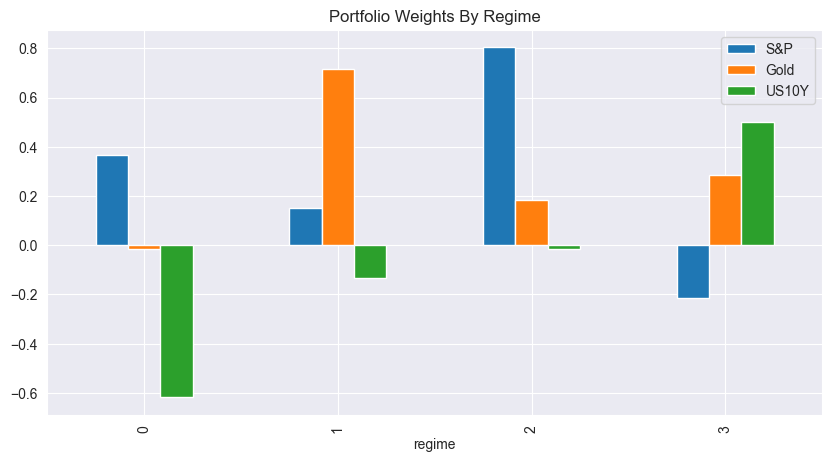

In [268]:

weights.plot(kind='bar', figsize=(10,5))
plt.title('Portfolio Weights By Regime')
plt.legend(['S&P', 'Gold', 'US10Y'])
plt.yticks()

In [264]:
weights

,SR,GR,YR
regime,,,
0,0.364879,-0.016527,-0.618593
1,0.151353,0.714411,-0.134237
2,0.803489,0.182847,-0.013664
3,-0.214408,0.286517,0.499075


We can see that in regime 1 (high inflation, low growth), gold is heavily weighted. In regime 3 (high growth, high inflation), the S&P is shorted.

# Performance

Once we compute the return series for our strategy, we can compare the performance to long S&P only. Since the signal is fixed (4 alpha vectors), there is no quantile analysis or other diagnostics.

To evaluate performance, we can look at cumulative returns and IR given by $$I.R = \frac{E[R_p - R_b]}{\sqrt{var[R_p - R_b]}}$$ and Sharpe/Sortino.

In [242]:
def quarterly_rets(row, weights):
    regime_weights = weights.iloc[int(row[-1])]
    return regime_weights.dot(row[:-1])

def get_strat_rets(df):
    return df.apply(quarterly_rets, weights=weights, axis=1)

def construct_perf(df, benchmark):
    perf = pd.DataFrame({'Strategy': get_strat_rets(df), 'Long S&P': benchmark}, index=df.index)
    perf['Tracking Error'] = perf.Strategy - perf['Long S&P']
    return perf

def ir(tracking_error, n):
    return (tracking_error.mean()*(n)/(tracking_error.std()* np.sqrt(n))).round(3)

train_perf = construct_perf(train, train.SR)
test_perf = construct_perf(test, test.SR)

In [245]:
print(f'In-sample period Information Ratio: {ir(train_perf["Tracking Error"], 4)}.')
print(f'In-sample period Sharpe: {sharpe(train_perf["Strategy"], 4, 0.04).round(3)}.')
print(f'In-sample period Sortino: {sharpe(train_perf["Strategy"], 4, 0.04, True).round(3)}.')
print('In-sample period long S&P Sharpe:', sharpe(train_perf['Long S&P'], 4, 0.02).round(3))
print('\n')
print(f'Out-sample period information ratio: {ir(test_perf["Tracking Error"], 4)}.')
print(f'Out-sample period Sharpe: {sharpe(test_perf["Strategy"], 4, 0.04).round(3)}.')
print(f'Out-sample period Sortino: {sharpe(test_perf["Strategy"], 4, 0.04, True).round(3)}.')
print('Out-sample period long S&P Sharpe:', sharpe(test_perf['Long S&P'], 4, 0.02).round(3))


In-sample period Information Ratio: 0.35.
In-sample period Sharpe: 0.629.
In-sample period Sortino: 1.276.
In-sample period long S&P Sharpe: 0.239


Out-sample period information ratio: 0.174.
Out-sample period Sharpe: 0.593.
Out-sample period Sortino: 1.057.
Out-sample period long S&P Sharpe: 0.532


Text(0.5, 1.0, 'Out-Sample Period Cumulative Return')

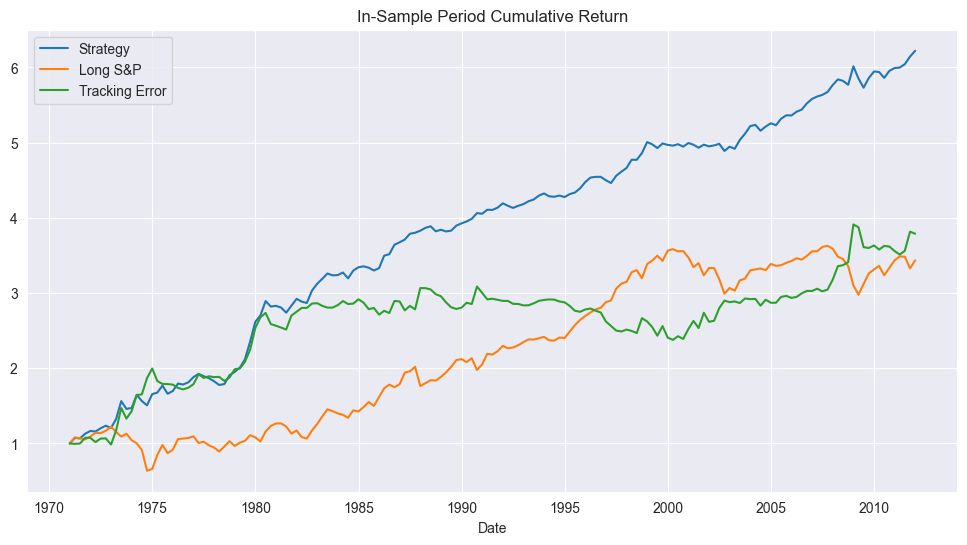

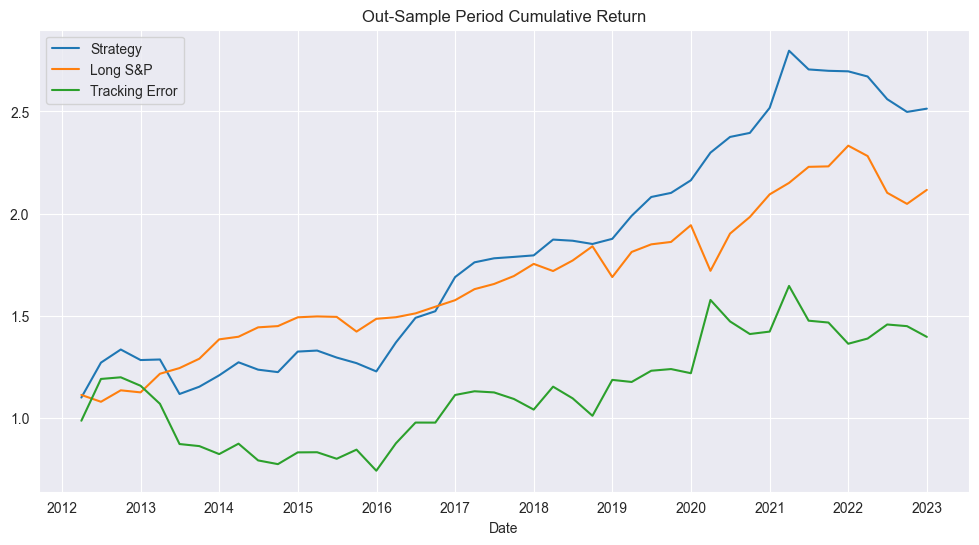

In [246]:

fig, ax = plt.subplots(figsize=(12,6))
year_locator = mdates.YearLocator(5)
ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


sns.lineplot(train_perf.cumsum().add(1), dashes=False)
plt.title('In-Sample Period Cumulative Return')

fig, ax = plt.subplots(figsize=(12,6))
year_locator = mdates.YearLocator(1)
ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

sns.lineplot(test_perf.cumsum().add(1), dashes=False)
plt.title('Out-Sample Period Cumulative Return')

Unfortunately, it does seem like the strategy overfits. Despite the cumulative return being higher than the S&P, the tracking error plots show many instances where it had lesser returns than the market index.

In [230]:
test_perf.tracking_error.describe()

count    44.000000
mean      0.009030
std       0.103890
min      -0.196606
25%      -0.052050
50%      -0.008580
75%       0.051916
max       0.358297
Name: tracking_error, dtype: float64

Text(0.5, 1.0, 'Out-Sample Period Tracking Error Scatterplot')

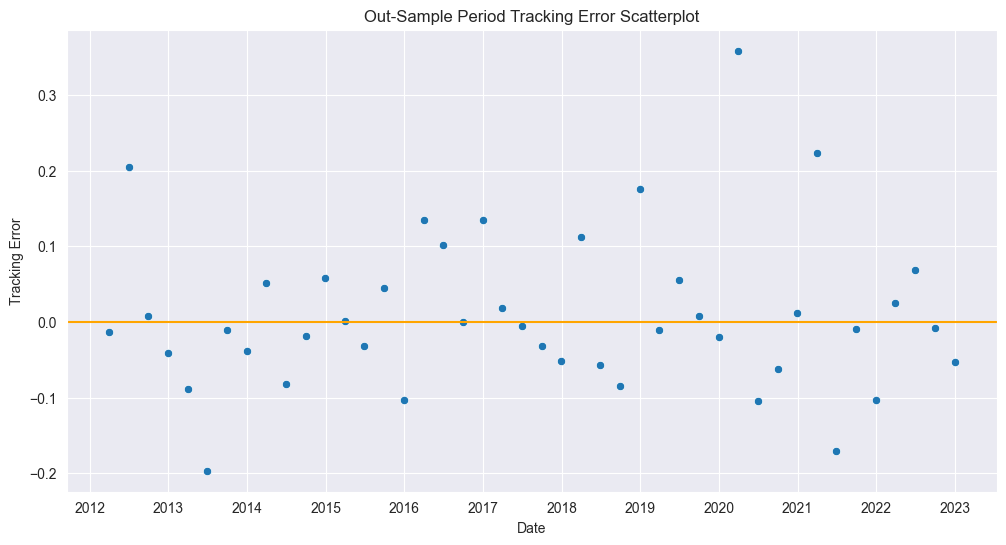

In [251]:
fig, ax = plt.subplots(figsize=(12,6))
year_locator = mdates.YearLocator(1)
ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
sns.scatterplot(test_perf["Tracking Error"], markers=True)
plt.axhline(y=0, color='orange')
plt.title('Out-Sample Period Tracking Error Scatterplot')

Text(0.5, 1.0, 'Out-Sample Period Tracking Error Histogram')

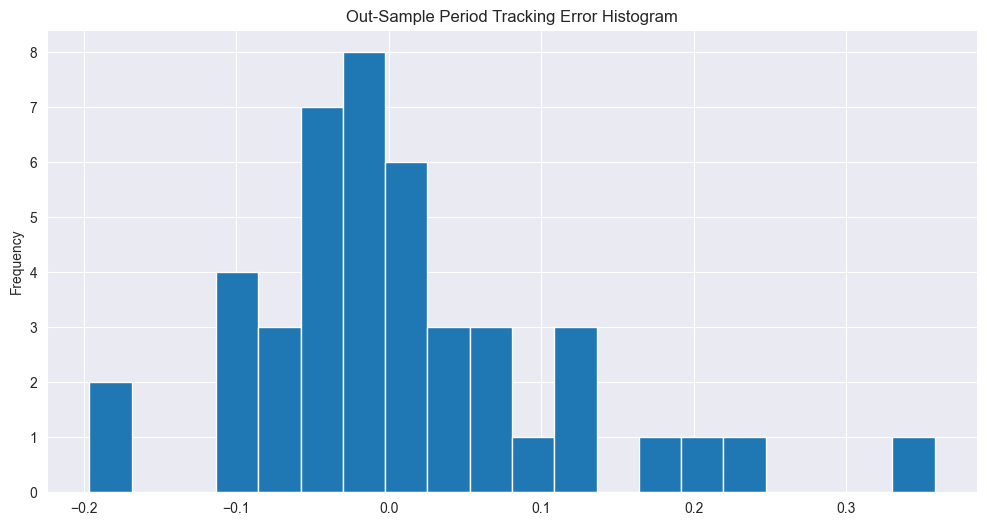

In [256]:
fig, ax = plt.subplots(figsize=(12,6))
test_perf["Tracking Error"].plot(kind='hist', bins=20)
plt.title('Out-Sample Period Tracking Error Histogram')

Looking at the out-sample 1Y rolling information ratio and Sharpe ratio, we see more evidence of the strategy failing to perform in the Covid era and beyond, showing a decrease in 2020 onwards with a slight positive upturn at the end of the out-sample period (mid 2022). Thus, it seems like a case of overfitting.

Text(0.5, 1.0, 'Out-Sample Period 1Y rolling IR')

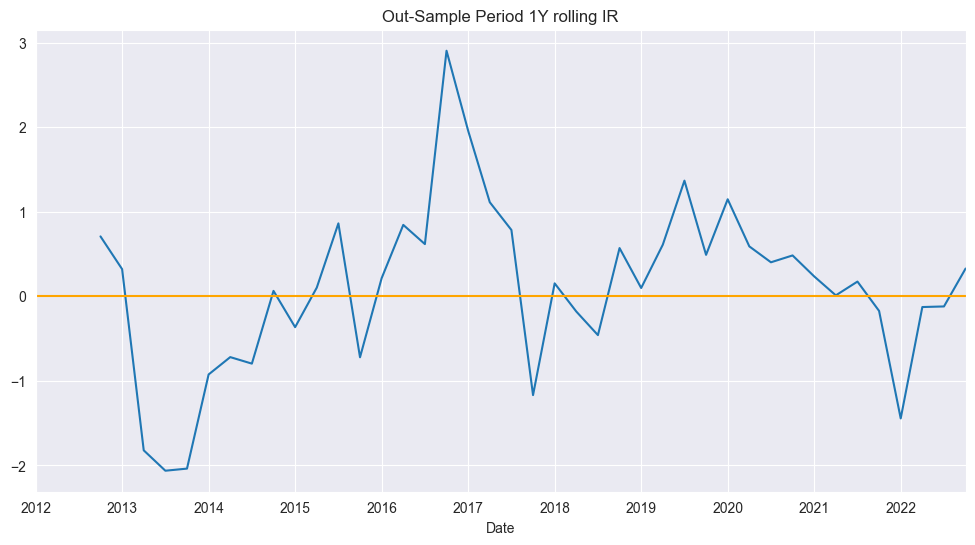

In [276]:
fig, ax = plt.subplots(figsize=(12,6))
test_perf["Tracking Error"].rolling(window=3).apply(ir, raw=False, args=(4,)).plot(kind='line')
plt.axhline(y=0, color='orange')
plt.title('Out-Sample Period 1Y rolling IR')

Text(0.5, 1.0, 'Out-Sample Period 1Y rolling Sharpe')

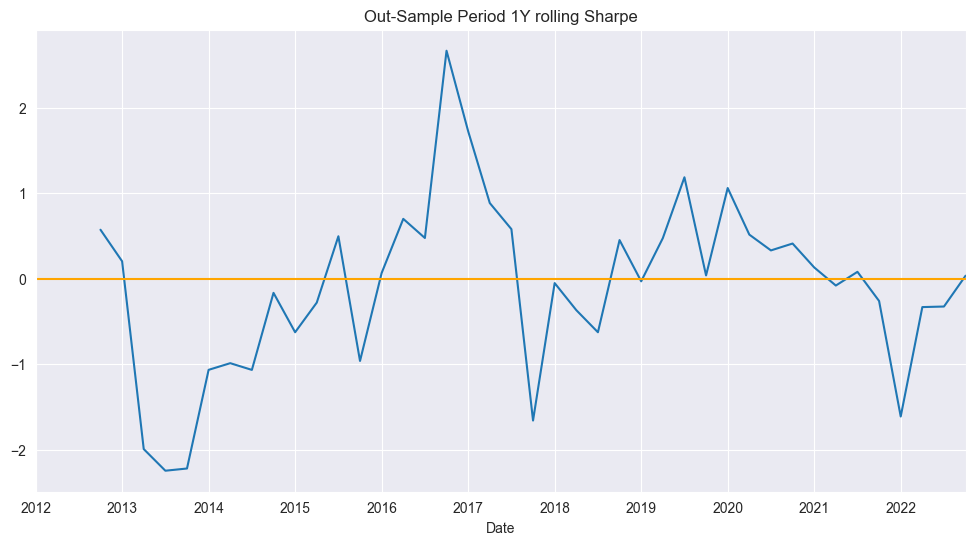

In [272]:
fig, ax = plt.subplots(figsize=(12,6))
test_perf["Tracking Error"].rolling(window=4).apply(sharpe, raw=False, args=(4,0.03)).plot(kind='line')
plt.axhline(y=0, color='orange')
plt.title('Out-Sample Period 1Y rolling Sharpe')

# Conclusion

Unfortunately, the strategy seems to be very naive and underperforms with negative rolling IR and Sharpe towards the end of the out-sample period. Also, the method of classifying regimes is simple and naive.

 However, this was a good exercise in getting my hands dirty with some financial data and playing around. Furthermore, it was made aware to me that my strategy had lookahead bias, as the quarterly GDP/CPI YoY figures were usually released after a quarter had already started. Thus, I was prompted that possibly lookahead macro indicators could be used as proxies of inflation and growth.